In [ ]:
!pip install jcopdl==1.1.1

In [ ]:
import jcopdl
jcopdl.__version__

'1.1.1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

torch.__version__
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xnSudZ1eoV6TbU6V0Gyt")
project = rf.workspace("haqqi").project("chicken-disease-avk9p")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...


# Dataset and Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("/content/Chicken-Disease-1/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("/content/Chicken-Disease-1/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
feature, target = next(iter(trainloader))
feature.shape

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


torch.Size([64, 3, 224, 224])

In [ ]:
label2cat = train_set.classes
label2cat

['Coccidiosis', 'Healthy', 'NewCastleDisease', 'Salmonella']

# Arsitektur dan Config

In [ ]:
from torchvision.models import densenet121

densenet = densenet121(pretrained=True)

for param in densenet.parameters():
  param.requires_grad = False

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 68.1MB/s]


In [ ]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet.classifier = nn.Sequential(
    nn.Linear(1024, 4),
    nn.LogSoftmax()
)

In [ ]:
class CustomDenseNet(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.densenet = densenet121(pretrained=True)
    self.freeze()
    self.densenet.classifier = nn.Sequential(
        nn.Linear(1024, 4),
        nn.LogSoftmax()
    )
  def forward(self, x):
    return self.densenet(x)

  def freeze(self):
    for param in self.densenet.features.parameters():
      param.requires_grad=False

  def unfreeze(self):
    for param in self.densenet.parameters():
      param.requires_grad=True

In [ ]:
config = set_config ({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation and Training Loop

## Phase 1: Adaptation

In [ ]:
model = CustomDenseNet(config.output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Test: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]



Epoch     1
Train_cost  = 0.6840 | Test_cost  = 0.4732 | Train_score = 0.7680 | Test_score = 0.8375 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch     2
Train_cost  = 0.4011 | Test_cost  = 0.3837 | Train_score = 0.8646 | Test_score = 0.8670 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.14it/s]



Epoch     3
Train_cost  = 0.3374 | Test_cost  = 0.3461 | Train_score = 0.8853 | Test_score = 0.8778 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]



Epoch     4
Train_cost  = 0.3177 | Test_cost  = 0.2946 | Train_score = 0.8892 | Test_score = 0.9012 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]



Epoch     5
Train_cost  = 0.2807 | Test_cost  = 0.2775 | Train_score = 0.9073 | Test_score = 0.9094 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]



Epoch     6
Train_cost  = 0.2659 | Test_cost  = 0.2872 | Train_score = 0.9105 | Test_score = 0.8969 |
==> EarlyStop patience =  1 | Best test_score: 0.9094


Test: 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]



Epoch     7
Train_cost  = 0.2463 | Test_cost  = 0.2610 | Train_score = 0.9171 | Test_score = 0.9042 |
==> EarlyStop patience =  2 | Best test_score: 0.9094
==> Execute Early Stopping at epoch: 7 | Best test_score: 0.9094
==> Best model is saved at model


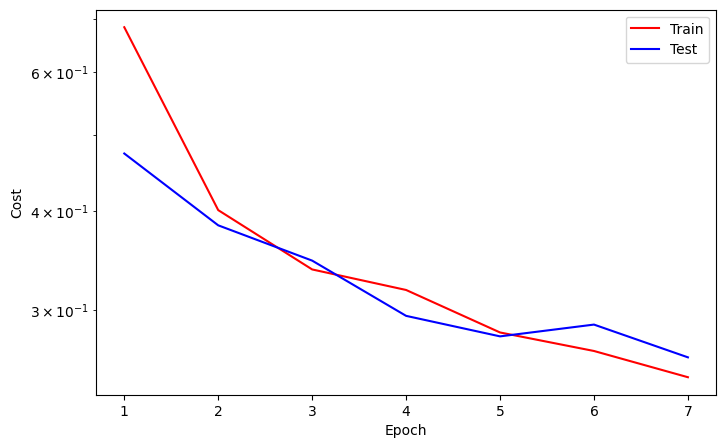

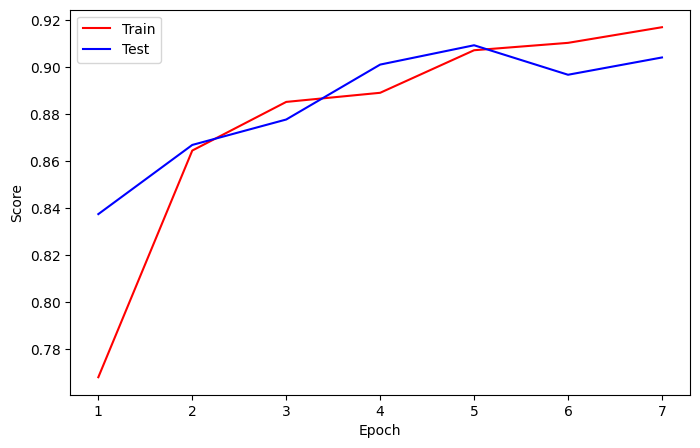

In [ ]:
from tqdm import tqdm

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Phase 2: fine-tuning

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience=5

Test: 100%|██████████| 37/37 [00:11<00:00,  3.17it/s]



Epoch     8
Train_cost  = 0.2174 | Test_cost  = 0.2077 | Train_score = 0.9297 | Test_score = 0.9307 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]



Epoch     9
Train_cost  = 0.1541 | Test_cost  = 0.1787 | Train_score = 0.9501 | Test_score = 0.9437 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]



Epoch    10
Train_cost  = 0.1287 | Test_cost  = 0.1498 | Train_score = 0.9560 | Test_score = 0.9510 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]



Epoch    11
Train_cost  = 0.1066 | Test_cost  = 0.1406 | Train_score = 0.9645 | Test_score = 0.9541 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    12
Train_cost  = 0.0863 | Test_cost  = 0.1305 | Train_score = 0.9739 | Test_score = 0.9541 |
==> EarlyStop patience =  1 | Best test_score: 0.9541


Test: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]



Epoch    13
Train_cost  = 0.0733 | Test_cost  = 0.1248 | Train_score = 0.9765 | Test_score = 0.9575 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    14
Train_cost  = 0.0683 | Test_cost  = 0.1180 | Train_score = 0.9793 | Test_score = 0.9584 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]



Epoch    15
Train_cost  = 0.0610 | Test_cost  = 0.1150 | Train_score = 0.9804 | Test_score = 0.9606 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]



Epoch    16
Train_cost  = 0.0524 | Test_cost  = 0.1153 | Train_score = 0.9835 | Test_score = 0.9588 |
==> EarlyStop patience =  1 | Best test_score: 0.9606


Test: 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]



Epoch    17
Train_cost  = 0.0466 | Test_cost  = 0.1079 | Train_score = 0.9874 | Test_score = 0.9632 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    18
Train_cost  = 0.0426 | Test_cost  = 0.1086 | Train_score = 0.9880 | Test_score = 0.9619 |
==> EarlyStop patience =  1 | Best test_score: 0.9632


Test: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]



Epoch    19
Train_cost  = 0.0378 | Test_cost  = 0.1044 | Train_score = 0.9895 | Test_score = 0.9649 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]



Epoch    20
Train_cost  = 0.0330 | Test_cost  = 0.1072 | Train_score = 0.9904 | Test_score = 0.9632 |


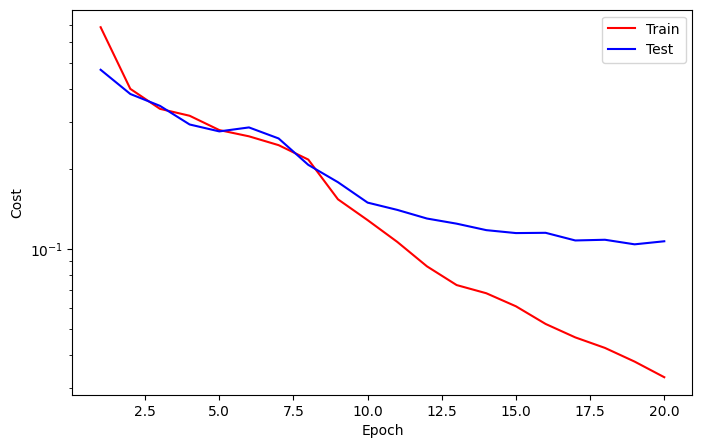

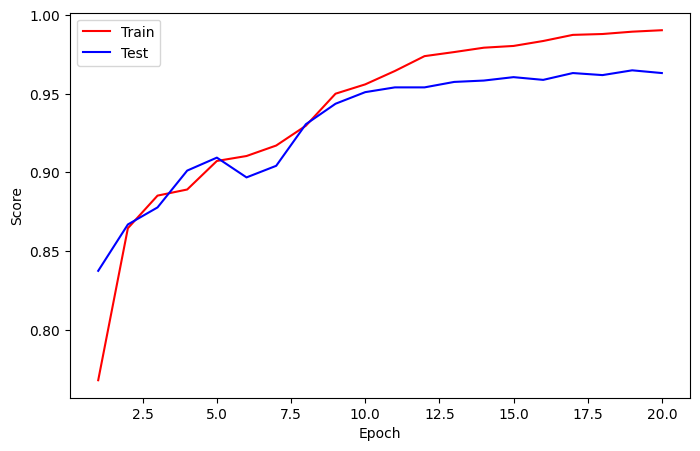

==> EarlyStop patience =  1 | Best test_score: 0.9649


Test: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]



Epoch    21
Train_cost  = 0.0300 | Test_cost  = 0.1015 | Train_score = 0.9915 | Test_score = 0.9649 |
==> EarlyStop patience =  2 | Best test_score: 0.9649


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    22
Train_cost  = 0.0264 | Test_cost  = 0.1014 | Train_score = 0.9939 | Test_score = 0.9671 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.25it/s]



Epoch    23
Train_cost  = 0.0245 | Test_cost  = 0.0996 | Train_score = 0.9941 | Test_score = 0.9658 |
==> EarlyStop patience =  1 | Best test_score: 0.9671


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    24
Train_cost  = 0.0223 | Test_cost  = 0.0988 | Train_score = 0.9945 | Test_score = 0.9671 |
==> EarlyStop patience =  2 | Best test_score: 0.9671


Test: 100%|██████████| 37/37 [00:11<00:00,  3.21it/s]



Epoch    25
Train_cost  = 0.0198 | Test_cost  = 0.1012 | Train_score = 0.9956 | Test_score = 0.9666 |
==> EarlyStop patience =  3 | Best test_score: 0.9671


Test: 100%|██████████| 37/37 [00:11<00:00,  3.30it/s]



Epoch    26
Train_cost  = 0.0179 | Test_cost  = 0.1007 | Train_score = 0.9967 | Test_score = 0.9662 |
==> EarlyStop patience =  4 | Best test_score: 0.9671


Test: 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]



Epoch    27
Train_cost  = 0.0175 | Test_cost  = 0.1005 | Train_score = 0.9959 | Test_score = 0.9679 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]



Epoch    28
Train_cost  = 0.0182 | Test_cost  = 0.1004 | Train_score = 0.9957 | Test_score = 0.9692 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]



Epoch    29
Train_cost  = 0.0128 | Test_cost  = 0.1010 | Train_score = 0.9972 | Test_score = 0.9697 |


Test: 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]



Epoch    30
Train_cost  = 0.0112 | Test_cost  = 0.1018 | Train_score = 0.9993 | Test_score = 0.9666 |
==> EarlyStop patience =  1 | Best test_score: 0.9697


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    31
Train_cost  = 0.0101 | Test_cost  = 0.1007 | Train_score = 0.9989 | Test_score = 0.9688 |
==> EarlyStop patience =  2 | Best test_score: 0.9697


Test: 100%|██████████| 37/37 [00:11<00:00,  3.26it/s]



Epoch    32
Train_cost  = 0.0085 | Test_cost  = 0.1018 | Train_score = 0.9989 | Test_score = 0.9688 |
==> EarlyStop patience =  3 | Best test_score: 0.9697


Test: 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]



Epoch    33
Train_cost  = 0.0102 | Test_cost  = 0.1008 | Train_score = 0.9980 | Test_score = 0.9688 |
==> EarlyStop patience =  4 | Best test_score: 0.9697


Test: 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]



Epoch    34
Train_cost  = 0.0092 | Test_cost  = 0.1085 | Train_score = 0.9982 | Test_score = 0.9679 |
==> EarlyStop patience =  5 | Best test_score: 0.9697
==> Execute Early Stopping at epoch: 34 | Best test_score: 0.9697
==> Best model is saved at model


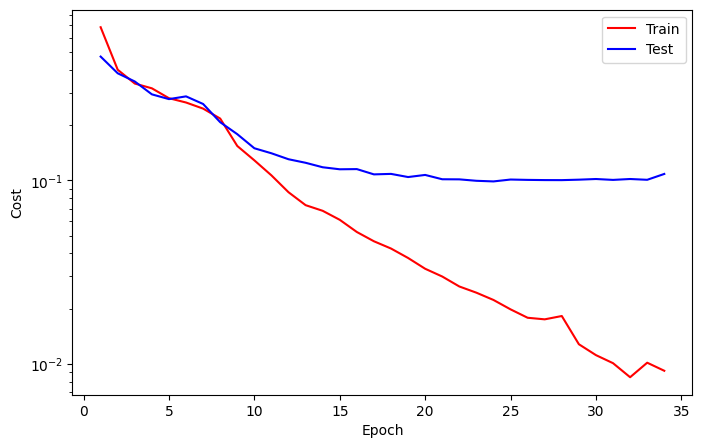

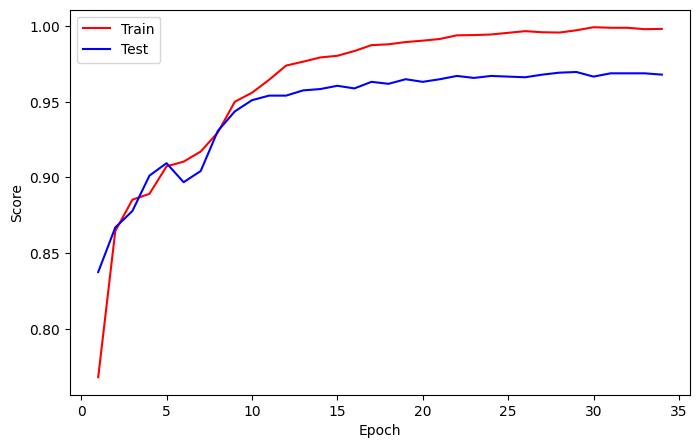

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [ ]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 7%)
  adding: content/model/logs.pth (deflated 32%)
  adding: content/model/configs.pth (deflated 58%)


# Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

In [ ]:
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Membalikkan normalisasi pada tensor gambar."""
    # Mean dan std perlu dikonversi ke "shape" yang sesuai untuk bisa dioperasikan dengan tensor gambar
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    if tensor.is_cuda:
        mean = mean.cuda()
        std = std.cuda()
    tensor = tensor * std + mean  # Menerapkan operasi berkebalikan
    tensor = torch.clamp(tensor, 0, 1)  # Memastikan nilai tetap dalam range [0, 1]
    return tensor

In [ ]:
unnormalized_features = unnormalize(feature)

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for image, label, pred, ax in zip(unnormalized_features, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": "r"} if label != pred else {"color": "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis("off");

Output hidden; open in https://colab.research.google.com to view.

# Predict New Image

In [ ]:
from PIL import Image

In [ ]:
# Buat transformasi yang sesuai untuk gambar baru
new_image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

# Fungsi untuk memprediksi gambar baru
def predict_new_image(image_path, model, label2cat):
    # Baca gambar dari path
    image = Image.open(image_path)

    # Terapkan transformasi
    image = new_image_transform(image)

    # Tambahkan batch dimension
    image = image.unsqueeze(0)

    # Pindahkan gambar ke perangkat yang sesuai (GPU atau CPU)
    image = image.to(device)

    # Mode evaluasi
    model.eval()

    # Lakukan prediksi
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(1).item()

    # Ambil label dari prediksi
    predicted_label = label2cat[pred]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_label}", fontdict=font)
    plt.axis("off")
    plt.show()

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


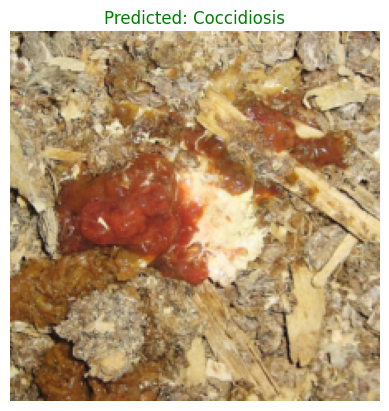

In [ ]:
image_path = "/content/Coccidiosis.jpg"
predict_new_image(image_path, model, label2cat)

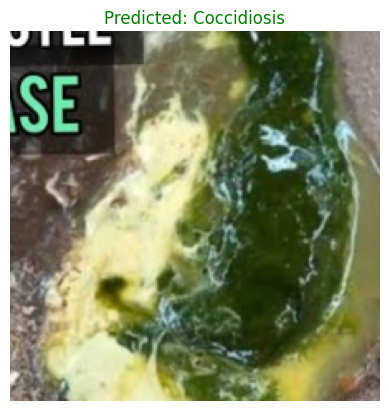

In [ ]:
image_path = "/content/NCD.jpg"
predict_new_image(image_path, model, label2cat)

EVALUASI

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

all_preds = []
all_targets = []

with torch.no_grad():
    model.eval()
    for feature, target in testloader:
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

accuracy = accuracy_score(all_targets, all_preds)
precision_per_class = precision_score(all_targets, all_preds, average='macro')
recall_per_class = recall_score(all_targets, all_preds, average='macro')
conf_matrix = confusion_matrix(all_targets, all_preds)

precision, recall, f_score, support = precision_recall_fscore_support(all_targets, all_preds)

class_names = label2cat

df_metrics = pd.DataFrame({
    'Class': class_names,
    'P': precision,
    'R': recall,
    'F_Score': f_score
})

pd.options.display.float_format = '{:,.2f}'.format

print(df_metrics.to_string(index=False))

print("\n\nAccuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision_per_class))
print("Recall: {:.2f}".format(recall_per_class))

              Class    P    R  F_Score
0       Coccidiosis 0.99 0.98     0.98
1           Healthy 0.96 0.97     0.96
2  NewCastleDisease 0.99 0.89     0.94
3        Salmonella 0.96 0.98     0.97
Accuracy: 0.9696707105719238
Precision: 0.9745769092169743
Recall: 0.9540099355193049


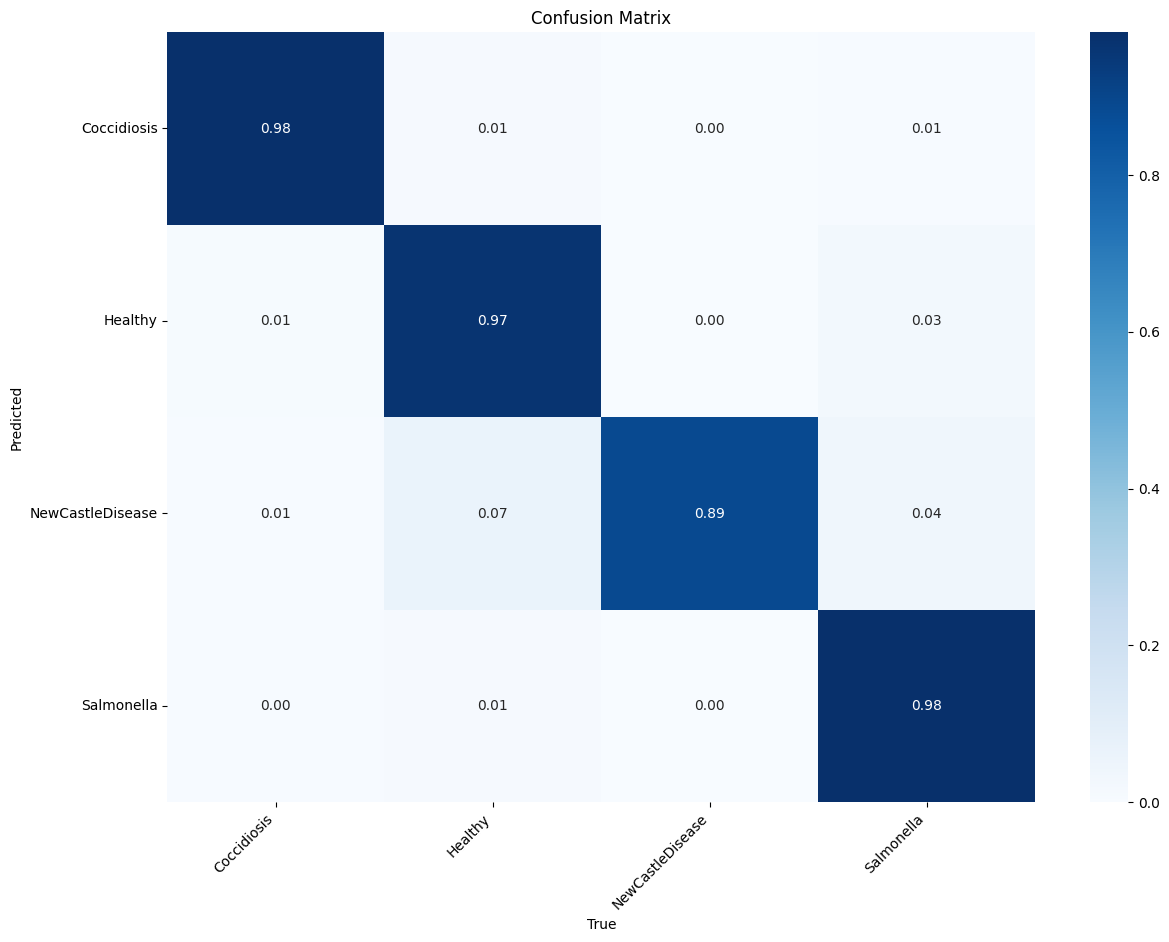

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_targets, all_preds)


conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 10))

sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.show()